In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone --branch baseline_boosting https://{token}@github.com/FrancescoZanella/RecSysChallenge2024.git
! git clone https://github.com/ebanalyse/ebnerd-benchmark.git

Cloning into 'RecSysChallenge2024'...
remote: Enumerating objects: 266, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 266 (delta 79), reused 220 (delta 52), pack-reused 0
Receiving objects: 100% (266/266), 16.69 MiB | 27.83 MiB/s, done.
Resolving deltas: 100% (79/79), done.
Cloning into 'ebnerd-benchmark'...
remote: Enumerating objects: 402, done.
remote: Counting objects: 100% (402/402), done.
remote: Compressing objects: 100% (269/269), done.
remote: Total 402 (delta 186), reused 320 (delta 109), pack-reused 0
Receiving objects: 100% (402/402), 15.22 MiB | 27.38 MiB/s, done.
Resolving deltas: 100% (186/186), done.


In [2]:
%cd /kaggle/working/RecSysChallenge2024/src

/kaggle/working/RecSysChallenge2024/src


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import polars as pl
import scipy.stats as stats
import gc

from ebrec.utils._descriptive_analysis import (
    min_max_impression_time_behaviors, 
    min_max_impression_time_history
)
from ebrec.utils._polars import slice_join_dataframes
from ebrec.utils._behaviors import (
    create_binary_labels_column,
    sampling_strategy_wu2019,
    truncate_history,
)
from ebrec.utils._constants import (
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_USER_COL
)
from ebrec.evaluation.metrics_protocols import *
from team_utils._catboost import add_features_JS_history_topics, add_trendiness_feature

from catboost import CatBoostClassifier

In [4]:
articles = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/articles.parquet')

behaviors_train = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/train/behaviors.parquet')
history_train = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/train/history.parquet')

behaviors_val = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/validation/behaviors.parquet')
history_val = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/validation/history.parquet')

# Articles Preprocessing

In [5]:
articles = articles.with_columns(
    pl.col('image_ids').list.len().alias('num_images'),
    pl.col('title').str.split(by=' ').list.len().alias('title_len'),
    pl.col('subtitle').str.split(by=' ').list.len().alias('subtitle_len'),
    pl.col('body').str.split(by=' ').list.len().alias('body_len'),
)
articles.head(2)

article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u32,u32,u32
3001353,"""Natascha var i…","""Politiet frygt…",2023-06-29 06:20:33,false,"""Sagen om den ø…",2006-08-31 08:06:45,[3150850],"""article_defaul…","""https://ekstra…",[],[],"[""Kriminalitet"", ""Personfarlig kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200
3003065,"""Kun Star Wars …","""Biografgængern…",2023-06-29 06:20:35,false,"""Vatikanet har …",2006-05-21 16:57:00,[3006712],"""article_defaul…","""https://ekstra…",[],[],"[""Underholdning"", ""Film og tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116


In [6]:
unique_entities = articles.select('entity_groups').explode('entity_groups')['entity_groups'].unique().to_list()
unique_entities = [e for e in unique_entities if e is not None]
unique_entities

['PROD', 'EVENT', 'LOC', 'ORG', 'MISC', 'PER']

In [7]:
unique_categories = articles.select('category')['category'].unique().to_list()
unique_categories = [c for c in unique_categories if c is not None]
len(unique_categories)

25

# Creating Training Dataframe

In [8]:
%%time

NPRATIO = 2

# dropping duplicates that can occur because of sampling strategy
train_ds = behaviors_train.pipe(sampling_strategy_wu2019, npratio=NPRATIO, shuffle=False, 
                                with_replacement=True, seed=123) \
    .pipe(add_trendiness_feature, articles=articles, days=3) \
    .pipe(create_binary_labels_column, shuffle=True, seed=123) \
    .select(['impression_id', 'article_ids_inview', 'article_id', 'impression_time', 'labels', 
             'device_type', 'read_time', 'scroll_percentage', 'user_id', 'is_sso_user', 'gender',
             'age', 'is_subscriber', 'session_id', 'trendiness_scores']) \
    .explode(['article_ids_inview', 'labels', 'trendiness_scores']) \
    .rename({'article_ids_inview': 'article', 'labels': 'target'}) \
    .unique(['impression_id', 'article']) \
    .with_columns(
        pl.col('impression_time').dt.weekday().alias('weekday'),
        pl.col('impression_time').dt.hour().alias('hour'),
        pl.col('article').cast(pl.Int32),
    ).join(articles.select(['article_id', 'premium', 'published_time', 'category',
                            'sentiment_score', 'sentiment_label', 'entity_groups',
                            'num_images', 'title_len', 'subtitle_len', 'body_len']),
           left_on='article', right_on='article_id', how='left') \
    .with_columns(
        (pl.col('impression_time') - pl.col('published_time')).dt.total_days().alias('article_delay_days'),
        (pl.col('impression_time') - pl.col('published_time')).dt.total_hours().alias('article_delay_hours')
    ).drop(['article_id']) \
    .with_columns(
        pl.col('entity_groups').list.contains(entity).alias(f'Entity_{entity}_Present')
        for entity in unique_entities
    )

train_ds.head()

CPU times: user 12min 23s, sys: 9min 19s, total: 21min 42s
Wall time: 17min 4s


impression_id,article,impression_time,target,device_type,read_time,scroll_percentage,user_id,is_sso_user,gender,age,is_subscriber,session_id,trendiness_scores,weekday,hour,premium,published_time,category,sentiment_score,sentiment_label,entity_groups,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_PROD_Present,Entity_EVENT_Present,Entity_LOC_Present,Entity_ORG_Present,Entity_MISC_Present,Entity_PER_Present
u32,i32,datetime[μs],i8,i8,f32,f32,u32,bool,i8,i8,bool,u32,i64,i8,i8,bool,datetime[μs],i16,f32,str,list[str],u32,u32,u32,u32,i64,i64,bool,bool,bool,bool,bool,bool
149474,9778669,2023-05-24 07:47:53,0,2,13.0,null,139836,false,null,null,false,759,90,3,7,false,2023-05-24 06:09:26,118,0.9481,"""Negative""","[""ORG"", ""ORG"", … ""PROD""]",1,5,11,150,0,1,true,false,false,true,false,true
149474,9778728,2023-05-24 07:47:53,0,2,13.0,null,139836,false,null,null,false,759,335,3,7,false,2023-05-24 07:26:05,142,0.9654,"""Negative""","[""EVENT"", ""EVENT"", … ""EVENT""]",1,5,18,251,0,0,true,true,false,true,false,true
150528,9778623,2023-05-24 07:33:25,1,2,25.0,null,143471,false,null,null,false,1240,165,3,7,false,2023-05-24 06:08:35,142,0.9893,"""Negative""","[""PER"", ""LOC"", … ""ORG""]",2,7,18,445,0,1,false,false,true,true,false,true
150528,9778682,2023-05-24 07:33:25,0,2,25.0,null,143471,false,null,null,false,1240,140,3,7,false,2023-05-24 06:32:42,498,0.9546,"""Negative""","[""PROD"", ""PROD"", … ""PER""]",1,5,20,267,0,1,true,true,false,true,false,true
153068,9778669,2023-05-24 07:09:04,1,1,78.0,100.0,151570,false,null,null,false,1976,140,3,7,false,2023-05-24 06:09:26,118,0.9481,"""Negative""","[""ORG"", ""ORG"", … ""PROD""]",1,5,11,150,0,0,true,false,false,true,false,true


In [9]:
train_ds.shape

(699537, 34)

## Session Features

In [10]:
# behaviors_train.select(['session_id', 'impression_time', 'article_ids_clicked']) \
#     .group_by('session_id').map_groups(
#         lambda group: group.explode('article_ids_clicked').sort('impression_time') \
#             .select(
#                 pl.col('session_id').first(),
#                 pl.col('article_ids_clicked').first().alias('article_id'),
#                 (pl.col('impression_time').last() - pl.col('impression_time').first()).dt.total_minutes().alias('induced_session_len'),
#                 (pl.col('impression_time').count() - 1).alias('num_clicked_articles_following')
#             )
#     ).group_by('article_id').agg(
#         pl.col('num_clicked_articles_following').mean().alias('mean_num_clicked_articles_following'),
#         pl.col('induced_session_len').mean().alias('mean_induced_session_len'),
#     )

In [11]:
%%time

last_history_df = history_train.with_columns(
    pl.col('impression_time_fixed').list.max().alias('last_history_impression_time'),
).select(['user_id', 'last_history_impression_time', 'article_id_fixed'])

last_session_time_df = behaviors_train.select(['session_id', 'user_id', 'impression_time', 'article_ids_inview', 'article_ids_clicked']) \
    .explode('article_ids_clicked') \
    .join(articles.select(['article_id', 'category']), left_on='article_ids_clicked', right_on='article_id', how='left') \
    .with_columns(
        # this is needed to the .flatten() that is done after
        pl.col('category').cast(pl.List(pl.Int64))
    ).group_by('session_id').agg(
        pl.col('user_id').first(), 
        pl.col('impression_time').max(), 
        pl.col('article_ids_inview').flatten().alias('all_seen_articles'),
        (pl.col('impression_time').max() - pl.col('impression_time').min()).dt.total_minutes().alias('session_duration'),
        pl.col('article_ids_clicked').count().alias('nclicks'),
        pl.col('category').flatten().alias('all_categories'),
    ).with_columns(
        pl.col('all_categories').map_elements(lambda x: stats.mode(x)[0], return_dtype=pl.Int64).alias('most_freq_category')
    ).group_by('user_id').map_groups(
        lambda user_impressions: user_impressions.sort('impression_time').with_columns(
            pl.col('impression_time').shift(1).alias('last_session_time'),
            pl.col('nclicks').shift(1).fill_null(0).alias('last_session_nclicks'),
            pl.col('session_duration').shift(1).fill_null(0).alias('last_session_duration'),
            pl.col('session_duration').rolling_mean(100, min_periods=1).alias('mean_prev_sessions_duration'),
            pl.col('most_freq_category').shift(1).alias('last_session_most_seen_category'),
            pl.col('all_seen_articles').list.unique().shift(1),
        )
    ).join(last_history_df, on='user_id', how='left') \
    .with_columns(
        pl.col('last_session_time').fill_null(pl.col('last_history_impression_time')),
        pl.col('all_seen_articles').fill_null(pl.col('article_id_fixed')),
    ).select(['session_id', 'last_session_time', 'last_session_nclicks', 'last_session_most_seen_category',
              'last_session_duration', 'all_seen_articles', 'mean_prev_sessions_duration'])
    
train_ds = train_ds.join(last_session_time_df, on='session_id', how='left').with_columns(
    (pl.col('impression_time') - pl.col('last_session_time')).dt.total_hours().alias('last_session_time_hour_diff'),
    ((pl.col('last_session_time') - pl.col('published_time')).dt.total_hours() > 0).alias('is_new_article'),
    pl.col('all_seen_articles').list.contains(pl.col('article')).alias('is_already_seen_article'),
    (pl.col('category') == pl.col('last_session_most_seen_category')).fill_null(False).alias('is_last_session_most_seen_category'),
).drop(['published_time', 'session_id', 'all_seen_articles', 'last_session_time', 'last_session_most_seen_category'])
train_ds.head(2)

CPU times: user 54 s, sys: 5.82 s, total: 59.8 s
Wall time: 54.8 s


impression_id,article,impression_time,target,device_type,read_time,scroll_percentage,user_id,is_sso_user,gender,age,is_subscriber,trendiness_scores,weekday,hour,premium,category,sentiment_score,sentiment_label,entity_groups,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_PROD_Present,Entity_EVENT_Present,Entity_LOC_Present,Entity_ORG_Present,Entity_MISC_Present,Entity_PER_Present,last_session_nclicks,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,is_last_session_most_seen_category
u32,i32,datetime[μs],i8,i8,f32,f32,u32,bool,i8,i8,bool,i64,i8,i8,bool,i16,f32,str,list[str],u32,u32,u32,u32,i64,i64,bool,bool,bool,bool,bool,bool,u32,i64,f64,i64,bool,bool,bool
149474,9778669,2023-05-24 07:47:53,0,2,13.0,null,139836,false,null,null,false,90,3,7,false,118,0.9481,"""Negative""","[""ORG"", ""ORG"", … ""PROD""]",1,5,11,150,0,1,true,false,false,true,false,true,3,1,1.0,88,false,false,true
149474,9778728,2023-05-24 07:47:53,0,2,13.0,null,139836,false,null,null,false,335,3,7,false,142,0.9654,"""Negative""","[""EVENT"", ""EVENT"", … ""EVENT""]",1,5,18,251,0,0,true,true,false,true,false,true,3,1,1.0,88,false,false,false


In [12]:
train_ds.select(pl.col('is_new_article').sum() / train_ds.shape[0], pl.col('is_already_seen_article').sum() / train_ds.shape[0])

is_new_article,is_already_seen_article
f64,f64
0.292472,0.089807


## Popularities

In [13]:
articles_date_popularity = articles.select(['published_time', 'article_id']) \
    .group_by(pl.col('published_time').dt.date().alias('published_date')) \
    .agg(pl.col('article_id').count().alias('daily_articles')) \

published_category_popularity = articles.select(['published_time', 'article_id', 'category']) \
    .group_by([pl.col('published_time').dt.date().alias('published_date'), 'category']) \
    .agg(pl.col('article_id').count().alias('category_daily_articles')) \
    .join(articles_date_popularity, on='published_date', how='left') \
    .with_columns((pl.col('category_daily_articles') / pl.col('daily_articles')).alias('category_daily_pct')) \
    .drop(['category_daily_articles', 'daily_articles'])

train_ds = train_ds.join(published_category_popularity, how='left', right_on=['published_date', 'category'],
                         left_on=[pl.col('impression_time').dt.date() - pl.duration(days=1), 'category']) \
    .rename({'category_daily_pct': 'yesterday_category_daily_pct'}).drop(['impression_time']) \
    .with_columns(pl.col('yesterday_category_daily_pct').fill_null(0))
train_ds.head(2)

impression_id,article,target,device_type,read_time,scroll_percentage,user_id,is_sso_user,gender,age,is_subscriber,trendiness_scores,weekday,hour,premium,category,sentiment_score,sentiment_label,entity_groups,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_PROD_Present,Entity_EVENT_Present,Entity_LOC_Present,Entity_ORG_Present,Entity_MISC_Present,Entity_PER_Present,last_session_nclicks,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,is_last_session_most_seen_category,yesterday_category_daily_pct
u32,i32,i8,i8,f32,f32,u32,bool,i8,i8,bool,i64,i8,i8,bool,i16,f32,str,list[str],u32,u32,u32,u32,i64,i64,bool,bool,bool,bool,bool,bool,u32,i64,f64,i64,bool,bool,bool,f64
149474,9778669,0,2,13.0,null,139836,false,null,null,false,90,3,7,false,118,0.9481,"""Negative""","[""ORG"", ""ORG"", … ""PROD""]",1,5,11,150,0,1,true,false,false,true,false,true,3,1,1.0,88,false,false,true,0.275362
149474,9778728,0,2,13.0,null,139836,false,null,null,false,335,3,7,false,142,0.9654,"""Negative""","[""EVENT"", ""EVENT"", … ""EVENT""]",1,5,18,251,0,0,true,true,false,true,false,true,3,1,1.0,88,false,false,false,0.246377


# Adding history features

In [14]:
%%time

from rich.progress import Progress


def get_single_feature_function(f_name, progress_task):
    def get_feature(article_ids):
        progress.update(progress_task, advance=1)
        feature_values = articles.filter(pl.col('article_id').is_in(article_ids)) \
            .select(pl.col(f_name))[f_name].to_list()
        return feature_values
    return get_feature


def get_unique_list_feature_function(f_name, progress_task):
    def get_feature(article_ids):
        progress.update(progress_task, advance=1)
        feature_values = articles.filter(pl.col('article_id').is_in(article_ids)) \
            .select(pl.col(f_name).list.unique())[f_name].to_list()
        return feature_values
    return get_feature


def get_unique_list_exploded_feature_function(f_name, progress_task):
    def get_feature(article_ids):
        progress.update(progress_task, advance=1)
        feature_values = articles.filter(pl.col('article_id').is_in(article_ids)) \
            .select(pl.col(f_name).list.unique()).explode(f_name)[f_name].to_list()
        return feature_values
    return get_feature


# ner_clusters for the moment is not used since there are too much unique values (more than 44k)
columns = ['category', 'article_type', 'sentiment_label', 'sentiment_score']
return_dtypes = [pl.Int64, pl.String, pl.String, pl.Float64]
with Progress() as progress: 
    
    tasks = {}
    for col in columns:
        tasks[col] = progress.add_task(f"Getting {col}", total=history_train.shape[0])
    tasks['entity_groups'] = progress.add_task("Getting entity_groups", total=history_train.shape[0])
    tasks['entity_groups_detailed'] = progress.add_task("Getting detailed entity_groups", total=history_train.shape[0])
    tasks['topics'] = progress.add_task("Getting topics", total=history_train.shape[0])

    history_train = history_train.with_columns(
        [pl.col('article_id_fixed').map_elements(get_single_feature_function(col, tasks[col]), 
                                                 return_dtype=pl.List(dtype)).alias(col)
         for col, dtype in zip(columns, return_dtypes)] + \
        [pl.col('article_id_fixed').map_elements(get_unique_list_exploded_feature_function('entity_groups', tasks['entity_groups']), 
                                                 return_dtype=pl.List(pl.String)).alias('entity_groups'),
         pl.col('article_id_fixed').map_elements(get_unique_list_exploded_feature_function('topics', tasks['topics']), 
                                                 return_dtype=pl.List(pl.String)).alias('topics_flatten'),
         pl.col('article_id_fixed').map_elements(get_unique_list_feature_function('entity_groups', tasks['entity_groups_detailed']), 
                                                 return_dtype=pl.List(pl.List(pl.String))).alias('entity_groups_detailed')]
    )
    
history_train.head(2)

Output()

CPU times: user 3min 15s, sys: 14.4 s, total: 3min 30s
Wall time: 2min 19s


user_id,impression_time_fixed,scroll_percentage_fixed,article_id_fixed,read_time_fixed,category,article_type,sentiment_label,sentiment_score,entity_groups,topics_flatten,entity_groups_detailed
u32,list[datetime[μs]],list[f32],list[i32],list[f32],list[i64],list[str],list[str],list[f64],list[str],list[str],list[list[str]]
13538,"[2023-04-27 10:17:43, 2023-04-27 10:18:01, … 2023-05-17 20:36:34]","[100.0, 35.0, … 100.0]","[9738663, 9738569, … 9769366]","[17.0, 12.0, … 16.0]","[565, 572, … 140]","[""article_default"", ""article_fullscreen_gallery"", … ""article_default""]","[""Neutral"", ""Neutral"", … ""Negative""]","[0.8108, 0.7985, … 0.9959]","[null, null, … ""ORG""]","[""Erotik"", ""Livsstil"", … ""Personfarlig kriminalitet""]","[[], [], … [""PER"", ""ORG"", ""LOC""]]"
14241,"[2023-04-27 09:40:18, 2023-04-27 09:40:33, … 2023-05-17 17:08:41]","[100.0, 46.0, … 100.0]","[9738557, 9738528, … 9767852]","[8.0, 9.0, … 12.0]","[457, 457, … 118]","[""article_default"", ""article_default"", … ""article_default""]","[""Negative"", ""Neutral"", … ""Neutral""]","[0.9712, 0.9115, … 0.8372]","[null, ""ORG"", … ""ORG""]","[""Livsstil"", ""Samfund"", … ""Økonomi""]","[[], [""PER"", ""ORG""], … [""PER"", ""ORG""]]"


## Basic Features

In [15]:
def sentiment_score_strong_pct(labels, scores, label_name, threshold=0.8):
    scores_filter = np.array(labels) == label_name
    label_scores = np.array(scores)[scores_filter]
    return np.sum(label_scores > threshold) / len(labels) if len(label_scores) > 0 else 0

history_train = history_train.with_columns(
    pl.struct(['sentiment_label', 'sentiment_score']).map_elements(
        lambda x: sentiment_score_strong_pct(x['sentiment_label'], x['sentiment_score'], 'Negative')
    ).alias('PctStrongNegative'),
    pl.struct(['sentiment_label', 'sentiment_score']).map_elements(
        lambda x: sentiment_score_strong_pct(x['sentiment_label'], x['sentiment_score'], 'Neutral')
    ).alias('PctStrongNeutral'),
    pl.struct(['sentiment_label', 'sentiment_score']).map_elements(
        lambda x: sentiment_score_strong_pct(x['sentiment_label'], x['sentiment_score'], 'Positive')
    ).alias('PctStrongPositive')
).with_columns(
    pl.col('read_time_fixed').list.len().alias('NumArticlesHistory'),
    pl.col('read_time_fixed').list.median().alias('MedianReadTime'),
    pl.col('read_time_fixed').list.max().alias('MaxReadTime'),
    pl.col('read_time_fixed').list.sum().alias('TotalReadTime'),
    pl.col('scroll_percentage_fixed').list.median().alias('MedianScrollPercentage'),
    pl.col('scroll_percentage_fixed').list.max().alias('MaxScrollPercentage'),
    pl.col('impression_time_fixed').list.eval(pl.element().dt.weekday()).alias('weekdays'),
    pl.col('impression_time_fixed').list.eval(pl.element().dt.hour()).alias('hours'),
).with_columns(
    pl.col('weekdays').map_elements(lambda x: stats.mode(x)[0], return_dtype=pl.Int64).cast(pl.Int8).alias('MostFrequentWeekday'),
    pl.col('hours').map_elements(lambda x: stats.mode(x)[0], return_dtype=pl.Int64).cast(pl.Int8).alias('MostFrequentHour'),
    pl.col('category').map_elements(lambda x: stats.mode(x)[0], return_dtype=pl.Int64).cast(pl.Int16).alias('MostFrequentCategory'),
    (1 - (pl.col('article_type').list.count_matches('article_default') / pl.col('NumArticlesHistory'))).alias('PctNotDefaultArticles'),
    (pl.col('sentiment_label').list.count_matches('Negative') / pl.col('NumArticlesHistory')).alias('NegativePct'),
    (pl.col('sentiment_label').list.count_matches('Positive') / pl.col('NumArticlesHistory')).alias('PositivePct'),
    (pl.col('sentiment_label').list.count_matches('Neutral') / pl.col('NumArticlesHistory')).alias('NeutralPct'),
).drop(
    ['read_time_fixed', 'scroll_percentage_fixed', 'impression_time_fixed', 
     'weekdays', 'hours', 'sentiment_label', 'sentiment_score', 'article_type']
).with_columns(
    (pl.col('entity_groups').list.count_matches(entity) / pl.col('NumArticlesHistory')).alias(f'{entity}Pct')
    for entity in unique_entities
).drop('entity_groups')

history_train.head(2)

user_id,article_id_fixed,category,topics_flatten,entity_groups_detailed,PctStrongNegative,PctStrongNeutral,PctStrongPositive,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,MostFrequentWeekday,MostFrequentHour,MostFrequentCategory,PctNotDefaultArticles,NegativePct,PositivePct,NeutralPct,PRODPct,EVENTPct,LOCPct,ORGPct,MISCPct,PERPct
u32,list[i32],list[i64],list[str],list[list[str]],f64,f64,f64,u32,f32,f32,f32,f32,f32,i8,i8,i16,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
13538,"[9738663, 9738569, … 9769366]","[565, 572, … 140]","[""Erotik"", ""Livsstil"", … ""Personfarlig kriminalitet""]","[[], [], … [""PER"", ""ORG"", ""LOC""]]",0.54792,0.115732,0.070524,582,6.0,672.0,7192.0,32.0,100.0,3,3,118,0.073883,0.601375,0.12543,0.223368,0.280069,0.159794,0.719931,0.87457,0.16323,0.819588
14241,"[9738557, 9738528, … 9767852]","[457, 457, … 118]","[""Livsstil"", ""Samfund"", … ""Økonomi""]","[[], [""PER"", ""ORG""], … [""PER"", ""ORG""]]",0.541401,0.146497,0.057325,179,19.0,1574.0,7754.0,100.0,100.0,3,13,118,0.139665,0.553073,0.094972,0.22905,0.206704,0.106145,0.681564,0.810056,0.162011,0.776536


In [16]:
history_train.shape

(15143, 27)

## Categories and entities

In [17]:
def list_pct_matches_with_col(a, b) -> pl.Expr:
    '''
    Returns an expression to count the number of matching element in a list with another column.
    The polars function count_matches cannot be used since it wants only a single element, 
    variable element from row to row.
    '''
    return pl.when(pl.col(a).list.len() == 0).then(0.0) \
        .otherwise((pl.col(a).list.len() - (pl.col(a).list.set_difference(pl.col(b))).list.len()) / pl.col(a).list.len())


train_ds = train_ds.join(history_train.drop(['entity_groups_detailed', 'article_id_fixed', 'topics_flatten']), on='user_id', how='left').with_columns(
    (pl.col('category') == pl.col('MostFrequentCategory')).alias('IsFavouriteCategory'),
    pl.col('category_right').list.n_unique().alias('NumberDifferentCategories'),
    list_pct_matches_with_col('category_right', 'category').alias('PctCategoryMatches'),
).drop('category_right')

gc.collect()
    
train_ds.head(2)

impression_id,article,target,device_type,read_time,scroll_percentage,user_id,is_sso_user,gender,age,is_subscriber,trendiness_scores,weekday,hour,premium,category,sentiment_score,sentiment_label,entity_groups,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_PROD_Present,Entity_EVENT_Present,Entity_LOC_Present,Entity_ORG_Present,Entity_MISC_Present,Entity_PER_Present,last_session_nclicks,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,is_last_session_most_seen_category,yesterday_category_daily_pct,PctStrongNegative,PctStrongNeutral,PctStrongPositive,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,MostFrequentWeekday,MostFrequentHour,MostFrequentCategory,PctNotDefaultArticles,NegativePct,PositivePct,NeutralPct,PRODPct,EVENTPct,LOCPct,ORGPct,MISCPct,PERPct,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches
u32,i32,i8,i8,f32,f32,u32,bool,i8,i8,bool,i64,i8,i8,bool,i16,f32,str,list[str],u32,u32,u32,u32,i64,i64,bool,bool,bool,bool,bool,bool,u32,i64,f64,i64,bool,bool,bool,f64,f64,f64,f64,u32,f32,f32,f32,f32,f32,i8,i8,i16,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,u32,f64
149474,9778669,0,2,13.0,null,139836,false,null,null,false,90,3,7,false,118,0.9481,"""Negative""","[""ORG"", ""ORG"", … ""PROD""]",1,5,11,150,0,1,true,false,false,true,false,true,3,1,1.0,88,false,false,true,0.275362,0.631579,0.210526,0.0,19,11.0,88.0,399.0,47.0,100.0,5,19,118,0.052632,0.736842,0.0,0.263158,0.105263,0.105263,0.789474,0.894737,0.157895,0.894737,true,5,0.789474
149474,9778728,0,2,13.0,null,139836,false,null,null,false,335,3,7,false,142,0.9654,"""Negative""","[""EVENT"", ""EVENT"", … ""EVENT""]",1,5,18,251,0,0,true,true,false,true,false,true,3,1,1.0,88,false,false,false,0.246377,0.631579,0.210526,0.0,19,11.0,88.0,399.0,47.0,100.0,5,19,118,0.052632,0.736842,0.0,0.263158,0.105263,0.105263,0.789474,0.894737,0.157895,0.894737,false,5,0.789474


In [18]:
%%time

import tqdm

entities_df = pl.concat(
    (
        rows.select(['impression_id', 'user_id', 'article', 'entity_groups']) \
            .join(history_train.select(['user_id', 'entity_groups_detailed']), on='user_id', how='left') \
            .explode('entity_groups_detailed')
            .with_columns(
                pl.col('entity_groups').list.set_intersection(pl.col('entity_groups_detailed')).list.len().alias('common_entities')
            ).drop(['entity_groups_detailed', 'entity_groups']) \
            .group_by(['impression_id', 'article']).agg(
                pl.col('common_entities').mean().alias('MeanCommonEntities'),
                pl.col('common_entities').max().alias('MaxCommonEntities'),
            )
        for rows in tqdm.tqdm(train_ds.iter_slices(100), total=train_ds.shape[0] // 100)
    )
)
train_ds = train_ds.join(entities_df, on=['impression_id', 'article'], how='left').drop(['entity_groups'])
train_ds.head(2)

6996it [02:48, 41.45it/s]


CPU times: user 2min 55s, sys: 16.6 s, total: 3min 11s
Wall time: 2min 48s


impression_id,article,target,device_type,read_time,scroll_percentage,user_id,is_sso_user,gender,age,is_subscriber,trendiness_scores,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_PROD_Present,Entity_EVENT_Present,Entity_LOC_Present,Entity_ORG_Present,Entity_MISC_Present,Entity_PER_Present,last_session_nclicks,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,is_last_session_most_seen_category,yesterday_category_daily_pct,PctStrongNegative,PctStrongNeutral,PctStrongPositive,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,MostFrequentWeekday,MostFrequentHour,MostFrequentCategory,PctNotDefaultArticles,NegativePct,PositivePct,NeutralPct,PRODPct,EVENTPct,LOCPct,ORGPct,MISCPct,PERPct,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches,MeanCommonEntities,MaxCommonEntities
u32,i32,i8,i8,f32,f32,u32,bool,i8,i8,bool,i64,i8,i8,bool,i16,f32,str,u32,u32,u32,u32,i64,i64,bool,bool,bool,bool,bool,bool,u32,i64,f64,i64,bool,bool,bool,f64,f64,f64,f64,u32,f32,f32,f32,f32,f32,i8,i8,i16,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,u32,f64,f64,u32
149474,9778669,0,2,13.0,null,139836,false,null,null,false,90,3,7,false,118,0.9481,"""Negative""",1,5,11,150,0,1,true,false,false,true,false,true,3,1,1.0,88,false,false,true,0.275362,0.631579,0.210526,0.0,19,11.0,88.0,399.0,47.0,100.0,5,19,118,0.052632,0.736842,0.0,0.263158,0.105263,0.105263,0.789474,0.894737,0.157895,0.894737,true,5,0.789474,1.894737,3
149474,9778728,0,2,13.0,null,139836,false,null,null,false,335,3,7,false,142,0.9654,"""Negative""",1,5,18,251,0,0,true,true,false,true,false,true,3,1,1.0,88,false,false,false,0.246377,0.631579,0.210526,0.0,19,11.0,88.0,399.0,47.0,100.0,5,19,118,0.052632,0.736842,0.0,0.263158,0.105263,0.105263,0.789474,0.894737,0.157895,0.894737,false,5,0.789474,2.0,3


## Topics TF-IDF Cosine Similarity

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
articles = articles.with_columns(
    pl.Series(
        vectorizer.fit_transform(
            articles.with_columns(pl.col('topics').list.join(separator=' '))['topics'].to_list()
        ).toarray()
    ).alias('topics_idf')
)
articles.head(2)

article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,topics_idf
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u32,u32,u32,list[f64]
3001353,"""Natascha var i…","""Politiet frygt…",2023-06-29 06:20:33,false,"""Sagen om den ø…",2006-08-31 08:06:45,[3150850],"""article_defaul…","""https://ekstra…",[],[],"[""Kriminalitet"", ""Personfarlig kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200,"[0.0, 0.0, … 0.0]"
3003065,"""Kun Star Wars …","""Biografgængern…",2023-06-29 06:20:35,false,"""Vatikanet har …",2006-05-21 16:57:00,[3006712],"""article_defaul…","""https://ekstra…",[],[],"[""Underholdning"", ""Film og tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116,"[0.0, 0.0, … 0.423101]"


In [20]:
history_train = history_train.with_columns(
    pl.Series(
        vectorizer.transform(
            history_train.with_columns(pl.col('topics_flatten').list.join(separator=' '))['topics_flatten'].to_list()
        ).toarray()
    ).alias('topics_flatten_idf')
)
history_train.head(2)

user_id,article_id_fixed,category,topics_flatten,entity_groups_detailed,PctStrongNegative,PctStrongNeutral,PctStrongPositive,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,MostFrequentWeekday,MostFrequentHour,MostFrequentCategory,PctNotDefaultArticles,NegativePct,PositivePct,NeutralPct,PRODPct,EVENTPct,LOCPct,ORGPct,MISCPct,PERPct,topics_flatten_idf
u32,list[i32],list[i64],list[str],list[list[str]],f64,f64,f64,u32,f32,f32,f32,f32,f32,i8,i8,i16,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,list[f64]
13538,"[9738663, 9738569, … 9769366]","[565, 572, … 140]","[""Erotik"", ""Livsstil"", … ""Personfarlig kriminalitet""]","[[], [], … [""PER"", ""ORG"", ""LOC""]]",0.54792,0.115732,0.070524,582,6.0,672.0,7192.0,32.0,100.0,3,3,118,0.073883,0.601375,0.12543,0.223368,0.280069,0.159794,0.719931,0.87457,0.16323,0.819588,"[0.080458, 0.011595, … 0.122978]"
14241,"[9738557, 9738528, … 9767852]","[457, 457, … 118]","[""Livsstil"", ""Samfund"", … ""Økonomi""]","[[], [""PER"", ""ORG""], … [""PER"", ""ORG""]]",0.541401,0.146497,0.057325,179,19.0,1574.0,7754.0,100.0,100.0,3,13,118,0.139665,0.553073,0.094972,0.22905,0.206704,0.106145,0.681564,0.810056,0.162011,0.776536,"[0.051152, 0.0, … 0.169212]"


In [21]:
def cosine_similarity(x, y):
    x = np.array(x)
    y = np.array(y)
    normalization = np.linalg.norm(x, 2) * np.linalg.norm(y, 2)
    return np.dot(x, y) / normalization if normalization > 0 else 0

topics_similarity_df = pl.concat(
    (
        rows.select(["impression_id", "user_id", "article"])
            .join(articles.select('article_id', 'topics_idf'), left_on='article', right_on='article_id', how='left')
            .join(history_train.select(['user_id', 'topics_flatten_idf']), on="user_id",how="left")
            .with_columns(
                pl.struct(['topics_idf', 'topics_flatten_idf']).map_elements(
                    lambda x: cosine_similarity(x['topics_idf'], x['topics_flatten_idf']), return_dtype=pl.Float64
                ).cast(pl.Float32).alias('topics_cosine'),
            ).select(['impression_id', 'article', 'topics_cosine'])
        for rows in tqdm.tqdm(train_ds.iter_slices(100), total = train_ds.shape[0] // 100)
    )
)
train_ds = train_ds.join(topics_similarity_df, on=['impression_id', 'article'], how='left')
train_ds.head(2)

6996it [00:53, 129.99it/s]                          


impression_id,article,target,device_type,read_time,scroll_percentage,user_id,is_sso_user,gender,age,is_subscriber,trendiness_scores,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_PROD_Present,Entity_EVENT_Present,Entity_LOC_Present,Entity_ORG_Present,Entity_MISC_Present,Entity_PER_Present,last_session_nclicks,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,is_last_session_most_seen_category,yesterday_category_daily_pct,PctStrongNegative,PctStrongNeutral,PctStrongPositive,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,MostFrequentWeekday,MostFrequentHour,MostFrequentCategory,PctNotDefaultArticles,NegativePct,PositivePct,NeutralPct,PRODPct,EVENTPct,LOCPct,ORGPct,MISCPct,PERPct,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches,MeanCommonEntities,MaxCommonEntities,topics_cosine
u32,i32,i8,i8,f32,f32,u32,bool,i8,i8,bool,i64,i8,i8,bool,i16,f32,str,u32,u32,u32,u32,i64,i64,bool,bool,bool,bool,bool,bool,u32,i64,f64,i64,bool,bool,bool,f64,f64,f64,f64,u32,f32,f32,f32,f32,f32,i8,i8,i16,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,u32,f64,f64,u32,f32
149474,9778669,0,2,13.0,null,139836,false,null,null,false,90,3,7,false,118,0.9481,"""Negative""",1,5,11,150,0,1,true,false,false,true,false,true,3,1,1.0,88,false,false,true,0.275362,0.631579,0.210526,0.0,19,11.0,88.0,399.0,47.0,100.0,5,19,118,0.052632,0.736842,0.0,0.263158,0.105263,0.105263,0.789474,0.894737,0.157895,0.894737,true,5,0.789474,1.894737,3,0.216486
149474,9778728,0,2,13.0,null,139836,false,null,null,false,335,3,7,false,142,0.9654,"""Negative""",1,5,18,251,0,0,true,true,false,true,false,true,3,1,1.0,88,false,false,false,0.246377,0.631579,0.210526,0.0,19,11.0,88.0,399.0,47.0,100.0,5,19,118,0.052632,0.736842,0.0,0.263158,0.105263,0.105263,0.789474,0.894737,0.157895,0.894737,false,5,0.789474,2.0,3,0.212338


## Topics Jaccard

In [22]:
train_ds = add_features_JS_history_topics(train_ds, articles, history_train)
train_ds.head(2)

6996it [04:21, 26.78it/s]                          


impression_id,article,target,device_type,read_time,scroll_percentage,user_id,is_sso_user,gender,age,is_subscriber,trendiness_scores,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_PROD_Present,Entity_EVENT_Present,Entity_LOC_Present,Entity_ORG_Present,Entity_MISC_Present,Entity_PER_Present,last_session_nclicks,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,is_last_session_most_seen_category,yesterday_category_daily_pct,PctStrongNegative,PctStrongNeutral,PctStrongPositive,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,MostFrequentWeekday,MostFrequentHour,MostFrequentCategory,PctNotDefaultArticles,NegativePct,PositivePct,NeutralPct,PRODPct,EVENTPct,LOCPct,ORGPct,MISCPct,PERPct,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches,MeanCommonEntities,MaxCommonEntities,topics_cosine,mean_JS,min_JS,max_JS,std_JS
u32,i32,i8,i8,f32,f32,u32,bool,i8,i8,bool,i64,i8,i8,bool,i16,f32,str,u32,u32,u32,u32,i64,i64,bool,bool,bool,bool,bool,bool,u32,i64,f64,i64,bool,bool,bool,f64,f64,f64,f64,u32,f32,f32,f32,f32,f32,i8,i8,i16,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,u32,f64,f64,u32,f32,f64,f64,f64,f64
149474,9778669,0,2,13.0,null,139836,false,null,null,false,90,3,7,false,118,0.9481,"""Negative""",1,5,11,150,0,1,true,false,false,true,false,true,3,1,1.0,88,false,false,true,0.275362,0.631579,0.210526,0.0,19,11.0,88.0,399.0,47.0,100.0,5,19,118,0.052632,0.736842,0.0,0.263158,0.105263,0.105263,0.789474,0.894737,0.157895,0.894737,true,5,0.789474,1.894737,3,0.216486,0.085526,0.0,0.6,0.170236
149474,9778728,0,2,13.0,null,139836,false,null,null,false,335,3,7,false,142,0.9654,"""Negative""",1,5,18,251,0,0,true,true,false,true,false,true,3,1,1.0,88,false,false,false,0.246377,0.631579,0.210526,0.0,19,11.0,88.0,399.0,47.0,100.0,5,19,118,0.052632,0.736842,0.0,0.263158,0.105263,0.105263,0.789474,0.894737,0.157895,0.894737,false,5,0.789474,2.0,3,0.212338,0.076382,0.0,0.375,0.108557


In [23]:
train_ds.shape

(699537, 70)

# Training

In [24]:
train_ds = train_ds.with_columns(
    pl.col('gender').fill_null(2),
)
train_ds = train_ds.drop(['impression_id', 'article', 'user_id']).to_pandas()

categorical_columns = ['device_type', 'is_sso_user', 'gender', 'is_subscriber', 'weekday',
                       'premium', 'category', 'sentiment_label', 'is_new_article', 'is_already_seen_article',
                       'MostFrequentCategory', 'MostFrequentWeekday', 'IsFavouriteCategory',
                       'is_last_session_most_seen_category']
categorical_columns += [f'Entity_{entity}_Present' for entity in unique_entities]
train_ds[categorical_columns] = train_ds[categorical_columns].astype('category')

X = train_ds.drop(columns=['target'])
y = train_ds['target']

In [25]:
# just a simple model to be able to run an evaluation
model = CatBoostClassifier(cat_features=categorical_columns, iterations=500)

model.fit(X, y, verbose=25)

Learning rate set to 0.318943
0:	learn: 0.6263212	total: 874ms	remaining: 7m 16s
25:	learn: 0.5486908	total: 19.2s	remaining: 5m 49s
50:	learn: 0.5387040	total: 37.6s	remaining: 5m 31s
75:	learn: 0.5322254	total: 56.6s	remaining: 5m 15s
100:	learn: 0.5276554	total: 1m 15s	remaining: 4m 58s
125:	learn: 0.5239835	total: 1m 34s	remaining: 4m 41s
150:	learn: 0.5209188	total: 1m 53s	remaining: 4m 22s
175:	learn: 0.5182621	total: 2m 13s	remaining: 4m 4s
200:	learn: 0.5159430	total: 2m 31s	remaining: 3m 45s
225:	learn: 0.5138203	total: 2m 51s	remaining: 3m 27s
250:	learn: 0.5121444	total: 3m 10s	remaining: 3m 8s
275:	learn: 0.5104453	total: 3m 29s	remaining: 2m 49s
300:	learn: 0.5086765	total: 3m 47s	remaining: 2m 30s
325:	learn: 0.5071206	total: 4m 6s	remaining: 2m 11s
350:	learn: 0.5055070	total: 4m 25s	remaining: 1m 52s
375:	learn: 0.5042626	total: 4m 43s	remaining: 1m 33s
400:	learn: 0.5029718	total: 5m 2s	remaining: 1m 14s
425:	learn: 0.5017294	total: 5m 21s	remaining: 55.8s
450:	learn: 

In [26]:
%%time

from catboost import Pool

train_pool = Pool(X, y, cat_features=categorical_columns)
feature_importances = model.get_feature_importance(train_pool)

CPU times: user 4.77 s, sys: 27.2 ms, total: 4.8 s
Wall time: 4.71 s


Text(0.5, 1.0, 'Catboost Feature Importances')

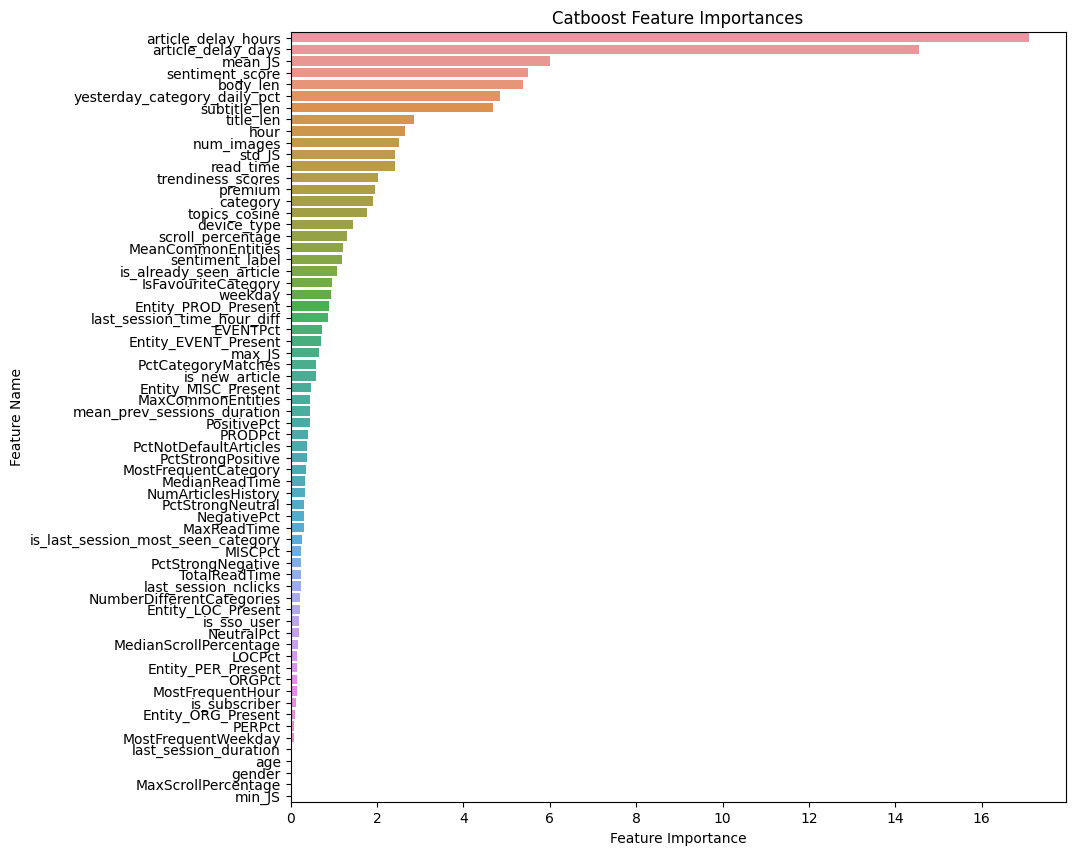

In [27]:
sorted_importances = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 10))
sns.barplot(x=feature_importances[sorted_importances], y=np.array(X.columns)[sorted_importances])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Catboost Feature Importances')

In [28]:
del history_train
del train_ds
del behaviors_train
gc.collect()

30

# Model Evaluation

In [29]:
last_history_df = history_val.with_columns(
    pl.col('impression_time_fixed').list.max().alias('last_history_impression_time'),
).select(['user_id', 'last_history_impression_time', 'article_id_fixed'])

last_session_time_df = behaviors_val.select(['session_id', 'user_id', 'impression_time', 'article_ids_inview', 'article_ids_clicked']) \
    .explode('article_ids_clicked') \
    .join(articles.select(['article_id', 'category']), left_on='article_ids_clicked', right_on='article_id', how='left') \
    .with_columns(
        # this is needed to the .flatten() that is done after
        pl.col('category').cast(pl.List(pl.Int64))
    ).group_by('session_id').agg(
        pl.col('user_id').first(), 
        pl.col('impression_time').max(), 
        pl.col('article_ids_inview').flatten().alias('all_seen_articles'),
        (pl.col('impression_time').max() - pl.col('impression_time').min()).dt.total_minutes().alias('session_duration'),
        pl.col('article_ids_clicked').count().alias('nclicks'),
        pl.col('category').flatten().alias('all_categories'),
    ).with_columns(
        pl.col('all_categories').map_elements(lambda x: stats.mode(x)[0], return_dtype=pl.Int64).alias('most_freq_category')
    ).group_by('user_id').map_groups(
        lambda user_impressions: user_impressions.sort('impression_time').with_columns(
            pl.col('impression_time').shift(1).alias('last_session_time'),
            pl.col('nclicks').shift(1).fill_null(0).alias('last_session_nclicks'),
            pl.col('session_duration').shift(1).fill_null(0).alias('last_session_duration'),
            pl.col('session_duration').rolling_mean(100, min_periods=1).alias('mean_prev_sessions_duration'),
            pl.col('most_freq_category').shift(1).alias('last_session_most_seen_category'),
            pl.col('all_seen_articles').list.unique().shift(1),
        )
    ).join(last_history_df, on='user_id', how='left') \
    .with_columns(
        pl.col('last_session_time').fill_null(pl.col('last_history_impression_time')),
        pl.col('all_seen_articles').fill_null(pl.col('article_id_fixed')),
    ).select(['session_id', 'last_session_time', 'last_session_nclicks', 'last_session_most_seen_category',
              'last_session_duration', 'all_seen_articles', 'mean_prev_sessions_duration'])

In [30]:
%%time

columns = ['category', 'article_type', 'sentiment_label', 'sentiment_score']
return_dtypes = [pl.Int64, pl.String, pl.String, pl.Float64]
with Progress() as progress: 
    
    tasks = {}
    for col in columns:
        tasks[col] = progress.add_task(f"Getting {col}", total=history_val.shape[0])
    tasks['entity_groups'] = progress.add_task("Getting entity_groups", total=history_val.shape[0])
    tasks['entity_groups_detailed'] = progress.add_task("Getting detailed entity_groups", total=history_val.shape[0])
    tasks['topics'] = progress.add_task("Getting topics", total=history_val.shape[0])

    history_val = history_val.with_columns(
        [pl.col('article_id_fixed').map_elements(get_single_feature_function(col, tasks[col]), 
                                                 return_dtype=pl.List(dtype)).alias(col)
         for col, dtype in zip(columns, return_dtypes)] + \
        [pl.col('article_id_fixed').map_elements(get_unique_list_exploded_feature_function('entity_groups', tasks['entity_groups']), 
                                                 return_dtype=pl.List(pl.String)).alias('entity_groups'),
         pl.col('article_id_fixed').map_elements(get_unique_list_exploded_feature_function('topics', tasks['topics']), 
                                                 return_dtype=pl.List(pl.String)).alias('topics_flatten'),
         pl.col('article_id_fixed').map_elements(get_unique_list_feature_function('entity_groups', tasks['entity_groups_detailed']), 
                                                 return_dtype=pl.List(pl.List(pl.String))).alias('entity_groups_detailed')]
    )
    
history_val = history_val.with_columns(
    pl.struct(['sentiment_label', 'sentiment_score']).map_elements(
        lambda x: sentiment_score_strong_pct(x['sentiment_label'], x['sentiment_score'], 'Negative')
    ).alias('PctStrongNegative'),
    pl.struct(['sentiment_label', 'sentiment_score']).map_elements(
        lambda x: sentiment_score_strong_pct(x['sentiment_label'], x['sentiment_score'], 'Neutral')
    ).alias('PctStrongNeutral'),
    pl.struct(['sentiment_label', 'sentiment_score']).map_elements(
        lambda x: sentiment_score_strong_pct(x['sentiment_label'], x['sentiment_score'], 'Positive')
    ).alias('PctStrongPositive')
).with_columns(
    pl.col('read_time_fixed').list.len().alias('NumArticlesHistory'),
    pl.col('read_time_fixed').list.median().alias('MedianReadTime'),
    pl.col('read_time_fixed').list.max().alias('MaxReadTime'),
    pl.col('read_time_fixed').list.sum().alias('TotalReadTime'),
    pl.col('scroll_percentage_fixed').list.median().alias('MedianScrollPercentage'),
    pl.col('scroll_percentage_fixed').list.max().alias('MaxScrollPercentage'),
    pl.col('impression_time_fixed').list.eval(pl.element().dt.weekday()).alias('weekdays'),
    pl.col('impression_time_fixed').list.eval(pl.element().dt.hour()).alias('hours'),
).with_columns(
    pl.col('weekdays').map_elements(lambda x: stats.mode(x)[0], return_dtype=pl.Int64).cast(pl.Int8).alias('MostFrequentWeekday'),
    pl.col('hours').map_elements(lambda x: stats.mode(x)[0], return_dtype=pl.Int64).cast(pl.Int8).alias('MostFrequentHour'),
    pl.col('category').map_elements(lambda x: stats.mode(x)[0], return_dtype=pl.Int64).cast(pl.Int16).alias('MostFrequentCategory'),
    (1 - (pl.col('article_type').list.count_matches('article_default') / pl.col('NumArticlesHistory'))).alias('PctNotDefaultArticles'),
    (pl.col('sentiment_label').list.count_matches('Negative') / pl.col('NumArticlesHistory')).alias('NegativePct'),
    (pl.col('sentiment_label').list.count_matches('Positive') / pl.col('NumArticlesHistory')).alias('PositivePct'),
    (pl.col('sentiment_label').list.count_matches('Neutral') / pl.col('NumArticlesHistory')).alias('NeutralPct'),
).drop(
    ['read_time_fixed', 'scroll_percentage_fixed', 'impression_time_fixed', 
     'weekdays', 'hours', 'sentiment_label', 'sentiment_score', 'article_type']
).with_columns(
    (pl.col('entity_groups').list.count_matches(entity) / pl.col('NumArticlesHistory')).alias(f'{entity}Pct')
    for entity in unique_entities
).drop('entity_groups')

history_val.head(2)

Output()

CPU times: user 3min 42s, sys: 20.7 s, total: 4min 3s
Wall time: 2min 49s


user_id,article_id_fixed,category,topics_flatten,entity_groups_detailed,PctStrongNegative,PctStrongNeutral,PctStrongPositive,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,MostFrequentWeekday,MostFrequentHour,MostFrequentCategory,PctNotDefaultArticles,NegativePct,PositivePct,NeutralPct,PRODPct,EVENTPct,LOCPct,ORGPct,MISCPct,PERPct
u32,list[i32],list[i64],list[str],list[list[str]],f64,f64,f64,u32,f32,f32,f32,f32,f32,i8,i8,i16,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
14241,"[9578072, 9749349, … 9779289]","[457, 457, … 118]","[""Erhverv"", ""Livsstil"", … ""International politik""]","[[], [""ORG"", ""PER""], … [""ORG"", ""LOC"", ""PER""]]",0.524476,0.167832,0.055944,161,18.0,1574.0,7608.0,98.0,100.0,3,13,118,0.130435,0.52795,0.10559,0.254658,0.180124,0.099379,0.701863,0.801242,0.136646,0.763975
20396,"[9748482, 9748916, … 9779489]","[140, 414, … 140]","[""Mindre ulykke"", ""Katastrofe"", … ""Personfarlig kriminalitet""]","[[""PER"", ""ORG"", ""LOC""], [""ORG"", ""LOC"", … ""PER""], … [""ORG"", ""LOC"", ""PER""]]",0.459016,0.180328,0.081967,74,40.5,1278.0,5406.0,100.0,100.0,7,15,414,0.22973,0.459459,0.121622,0.243243,0.256757,0.121622,0.648649,0.783784,0.216216,0.756757


In [31]:
# no sampling since for evaluation all the predictions should be needed
val_ds = behaviors_val.pipe(add_trendiness_feature, articles=articles, days=3) \
    .pipe(create_binary_labels_column, shuffle=True, seed=123) \
    .select(['impression_id', 'article_ids_inview', 'article_id', 'impression_time', 'labels', 
             'device_type', 'read_time', 'scroll_percentage', 'user_id', 'is_sso_user', 'gender',
             'age', 'is_subscriber', 'session_id', 'trendiness_scores']) \
    .explode(['article_ids_inview', 'labels', 'trendiness_scores']) \
    .rename({'article_ids_inview': 'article', 'labels': 'target'}) \
    .with_columns(
        pl.col('impression_time').dt.weekday().alias('weekday'),
        pl.col('impression_time').dt.hour().alias('hour'),
        pl.col('article').cast(pl.Int32),
    ).join(articles.select(['article_id', 'premium', 'published_time', 'category',
                            'sentiment_score', 'sentiment_label', 'entity_groups',
                            'num_images', 'title_len', 'subtitle_len', 'body_len']),
           left_on='article', right_on='article_id', how='left') \
    .with_columns(
        (pl.col('impression_time') - pl.col('published_time')).dt.total_days().alias('article_delay_days'),
        (pl.col('impression_time') - pl.col('published_time')).dt.total_hours().alias('article_delay_hours')
    ).drop(['article_id']) \
    .with_columns(
        pl.col('entity_groups').list.contains(entity).alias(f'Entity_{entity}_Present')
        for entity in unique_entities
    ).join(last_session_time_df, on='session_id', how='left').with_columns(
        (pl.col('impression_time') - pl.col('last_session_time')).dt.total_hours().alias('last_session_time_hour_diff'),
        ((pl.col('last_session_time') - pl.col('published_time')).dt.total_hours() > 0).alias('is_new_article'),
        pl.col('all_seen_articles').list.contains(pl.col('article')).alias('is_already_seen_article'),
        (pl.col('category') == pl.col('last_session_most_seen_category')).fill_null(False).alias('is_last_session_most_seen_category'),
    ).drop(['published_time', 'session_id', 'all_seen_articles', 'last_session_time', 'last_session_most_seen_category']) \
    .join(published_category_popularity, how='left', right_on=['published_date', 'category'],
          left_on=[pl.col('impression_time').dt.date() - pl.duration(days=1), 'category']) \
    .rename({'category_daily_pct': 'yesterday_category_daily_pct'}).drop(['impression_time']) \
    .with_columns(pl.col('yesterday_category_daily_pct').fill_null(0)) \
    .join(history_val.drop(['entity_groups_detailed', 'article_id_fixed', 'topics_flatten']), on='user_id', how='left').with_columns(
        (pl.col('category') == pl.col('MostFrequentCategory')).alias('IsFavouriteCategory'),
        pl.col('category_right').list.n_unique().alias('NumberDifferentCategories'),
        list_pct_matches_with_col('category_right', 'category').alias('PctCategoryMatches'),
    ).drop('category_right')
    
val_ds.head(2)

impression_id,article,target,device_type,read_time,scroll_percentage,user_id,is_sso_user,gender,age,is_subscriber,trendiness_scores,weekday,hour,premium,category,sentiment_score,sentiment_label,entity_groups,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_PROD_Present,Entity_EVENT_Present,Entity_LOC_Present,Entity_ORG_Present,Entity_MISC_Present,Entity_PER_Present,last_session_nclicks,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,is_last_session_most_seen_category,yesterday_category_daily_pct,PctStrongNegative,PctStrongNeutral,PctStrongPositive,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,MostFrequentWeekday,MostFrequentHour,MostFrequentCategory,PctNotDefaultArticles,NegativePct,PositivePct,NeutralPct,PRODPct,EVENTPct,LOCPct,ORGPct,MISCPct,PERPct,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches
u32,i32,i8,i8,f32,f32,u32,bool,i8,i8,bool,i64,i8,i8,bool,i16,f32,str,list[str],u32,u32,u32,u32,i64,i64,bool,bool,bool,bool,bool,bool,u32,i64,f64,i64,bool,bool,bool,f64,f64,f64,f64,u32,f32,f32,f32,f32,f32,i8,i8,i16,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,u32,f64
96791,9783865,0,2,9.0,null,22548,false,null,null,false,218,7,4,false,498,0.9793,"""Negative""","[""PROD"", ""PER"", … ""ORG""]",1,3,13,283,0,6,true,true,true,true,false,true,1,0,3.5,12,false,false,false,0.0625,0.503937,0.11811,0.094488,130,16.0,650.0,4581.0,37.0,100.0,1,9,118,0.061538,0.576923,0.153846,0.246154,0.292308,0.223077,0.715385,0.907692,0.176923,0.823077,false,7,0.952756
96791,9784591,0,2,9.0,null,22548,false,null,null,false,247,7,4,false,142,0.9823,"""Negative""","[""ORG"", ""LOC"", … ""ORG""]",7,7,12,302,0,8,false,false,true,true,false,true,1,0,3.5,12,false,false,true,0.357143,0.503937,0.11811,0.094488,130,16.0,650.0,4581.0,37.0,100.0,1,9,118,0.061538,0.576923,0.153846,0.246154,0.292308,0.223077,0.715385,0.907692,0.176923,0.823077,false,7,0.952756


In [32]:
val_ds.shape

(2928942, 64)

In [33]:
%%time

entities_df = pl.concat(
    (
        rows.select(['impression_id', 'user_id', 'article', 'entity_groups']) \
            .join(history_val.select(['user_id', 'entity_groups_detailed']), on='user_id', how='left') \
            .explode('entity_groups_detailed') \
            .with_columns(
                pl.col('entity_groups').list.set_intersection(pl.col('entity_groups_detailed')).list.len().alias('common_entities')
            ).drop(['entity_groups_detailed', 'entity_groups']) \
            .group_by(['impression_id', 'article']).agg(
                pl.col('common_entities').mean().alias('MeanCommonEntities'),
                pl.col('common_entities').max().alias('MaxCommonEntities'),
            )
        for rows in tqdm.tqdm(val_ds.iter_slices(100), total=val_ds.shape[0] // 100)
    )
)
val_ds = val_ds.join(entities_df, on=['impression_id', 'article'], how='left').drop(['entity_groups'])
val_ds.head(2)

29290it [11:17, 43.24it/s]                           


CPU times: user 11min 29s, sys: 1min 23s, total: 12min 52s
Wall time: 11min 18s


impression_id,article,target,device_type,read_time,scroll_percentage,user_id,is_sso_user,gender,age,is_subscriber,trendiness_scores,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_PROD_Present,Entity_EVENT_Present,Entity_LOC_Present,Entity_ORG_Present,Entity_MISC_Present,Entity_PER_Present,last_session_nclicks,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,is_last_session_most_seen_category,yesterday_category_daily_pct,PctStrongNegative,PctStrongNeutral,PctStrongPositive,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,MostFrequentWeekday,MostFrequentHour,MostFrequentCategory,PctNotDefaultArticles,NegativePct,PositivePct,NeutralPct,PRODPct,EVENTPct,LOCPct,ORGPct,MISCPct,PERPct,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches,MeanCommonEntities,MaxCommonEntities
u32,i32,i8,i8,f32,f32,u32,bool,i8,i8,bool,i64,i8,i8,bool,i16,f32,str,u32,u32,u32,u32,i64,i64,bool,bool,bool,bool,bool,bool,u32,i64,f64,i64,bool,bool,bool,f64,f64,f64,f64,u32,f32,f32,f32,f32,f32,i8,i8,i16,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,u32,f64,f64,u32
96791,9783865,0,2,9.0,null,22548,false,null,null,false,218,7,4,false,498,0.9793,"""Negative""",1,3,13,283,0,6,true,true,true,true,false,true,1,0,3.5,12,false,false,false,0.0625,0.503937,0.11811,0.094488,130,16.0,650.0,4581.0,37.0,100.0,1,9,118,0.061538,0.576923,0.153846,0.246154,0.292308,0.223077,0.715385,0.907692,0.176923,0.823077,false,7,0.952756,3.031496,5
96791,9784591,0,2,9.0,null,22548,false,null,null,false,247,7,4,false,142,0.9823,"""Negative""",7,7,12,302,0,8,false,false,true,true,false,true,1,0,3.5,12,false,false,true,0.357143,0.503937,0.11811,0.094488,130,16.0,650.0,4581.0,37.0,100.0,1,9,118,0.061538,0.576923,0.153846,0.246154,0.292308,0.223077,0.715385,0.907692,0.176923,0.823077,false,7,0.952756,2.503937,3


In [34]:
history_val = history_val.with_columns(
    pl.Series(
        vectorizer.transform(
            history_val.with_columns(pl.col('topics_flatten').list.join(separator=' '))['topics_flatten'].to_list()
        ).toarray()
    ).alias('topics_flatten_idf')
)

topics_similarity_df = pl.concat(
    (
        rows.select(["impression_id", "user_id", "article"])
            .join(articles.select('article_id', 'topics_idf'), left_on='article', right_on='article_id', how='left')
            .join(history_val.select(['user_id', 'topics_flatten_idf']), on="user_id",how="left")
            .with_columns(
                pl.struct(['topics_idf', 'topics_flatten_idf']).map_elements(
                    lambda x: cosine_similarity(x['topics_idf'], x['topics_flatten_idf']), return_dtype=pl.Float64
                ).cast(pl.Float32).alias('topics_cosine'),
            ).select(['impression_id', 'article', 'topics_cosine'])
        for rows in tqdm.tqdm(val_ds.iter_slices(100), total=val_ds.shape[0] // 100)
    )
)
val_ds = val_ds.join(topics_similarity_df, on=['impression_id', 'article'], how='left')
val_ds = add_features_JS_history_topics(val_ds, articles, history_val)
val_ds.head(2)

29290it [04:02, 120.78it/s]                           
29290it [16:41, 29.25it/s]


impression_id,article,target,device_type,read_time,scroll_percentage,user_id,is_sso_user,gender,age,is_subscriber,trendiness_scores,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_PROD_Present,Entity_EVENT_Present,Entity_LOC_Present,Entity_ORG_Present,Entity_MISC_Present,Entity_PER_Present,last_session_nclicks,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,is_last_session_most_seen_category,yesterday_category_daily_pct,PctStrongNegative,PctStrongNeutral,PctStrongPositive,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,MostFrequentWeekday,MostFrequentHour,MostFrequentCategory,PctNotDefaultArticles,NegativePct,PositivePct,NeutralPct,PRODPct,EVENTPct,LOCPct,ORGPct,MISCPct,PERPct,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches,MeanCommonEntities,MaxCommonEntities,topics_cosine,mean_JS,min_JS,max_JS,std_JS
u32,i32,i8,i8,f32,f32,u32,bool,i8,i8,bool,i64,i8,i8,bool,i16,f32,str,u32,u32,u32,u32,i64,i64,bool,bool,bool,bool,bool,bool,u32,i64,f64,i64,bool,bool,bool,f64,f64,f64,f64,u32,f32,f32,f32,f32,f32,i8,i8,i16,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,u32,f64,f64,u32,f32,f64,f64,f64,f64
96791,9783865,0,2,9.0,null,22548,false,null,null,false,218,7,4,false,498,0.9793,"""Negative""",1,3,13,283,0,6,true,true,true,true,false,true,1,0,3.5,12,false,false,false,0.0625,0.503937,0.11811,0.094488,130,16.0,650.0,4581.0,37.0,100.0,1,9,118,0.061538,0.576923,0.153846,0.246154,0.292308,0.223077,0.715385,0.907692,0.176923,0.823077,false,7,0.952756,3.031496,5,0.303267,0.106309,0.0,0.666667,0.139516
96791,9784591,0,2,9.0,null,22548,false,null,null,false,247,7,4,false,142,0.9823,"""Negative""",7,7,12,302,0,8,false,false,true,true,false,true,1,0,3.5,12,false,false,true,0.357143,0.503937,0.11811,0.094488,130,16.0,650.0,4581.0,37.0,100.0,1,9,118,0.061538,0.576923,0.153846,0.246154,0.292308,0.223077,0.715385,0.907692,0.176923,0.823077,false,7,0.952756,2.503937,3,0.431995,0.159201,0.0,1.0,0.288552


In [35]:
del history_val
del articles
del behaviors_val

gc.collect()

0

In [36]:
val_ds.shape

(2928942, 70)

In [37]:
val_ds = val_ds.with_columns(
    pl.col('gender').fill_null(2),
)
# impression_id will be later useful for evaluation
val_ds_pandas = val_ds.drop(['impression_id', 'article', 'user_id']).to_pandas()

val_ds_pandas[categorical_columns] = val_ds_pandas[categorical_columns].astype('category')

X_val = val_ds_pandas.drop(columns=['target'])
y_val = val_ds_pandas['target']

# doint model.predict_proba(...)[:, 1] to take only the probability of class 1
# while by doing [:, 0] we take the probability of class 0
val_ds = val_ds.with_columns(pl.Series(model.predict_proba(X_val)[:, 1]).alias('prediction'))
val_ds.select(['impression_id', 'target', 'prediction'])

impression_id,target,prediction
u32,i8,f64
96791,0,0.353689
96791,0,0.578463
96791,0,0.523753
96791,1,0.54642
96791,0,0.337622
…,…,…
579552453,0,0.159942
579552453,0,0.076742
579552453,0,0.12541


In [38]:
evaluation_ds = val_ds.group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))
evaluation_ds

impression_id,target,prediction
u32,list[i8],list[f64]
156930898,"[0, 0, … 0]","[0.032374, 0.567771, … 0.060922]"
114675027,"[0, 0, … 0]","[0.575009, 0.364882, … 0.404096]"
98070159,"[0, 0, … 0]","[0.076904, 0.05309, … 0.043007]"
123978273,"[0, 0, … 0]","[0.299889, 0.210608, … 0.123726]"
116626960,"[0, 0, … 1]","[0.183058, 0.284488, … 0.370028]"
…,…,…
309426683,"[1, 0, … 0]","[0.11399, 0.286992, … 0.367519]"
361862679,"[0, 0, … 0]","[0.592931, 0.177958, … 0.494689]"
461012899,"[0, 0, … 0]","[0.204896, 0.291375, … 0.41679]"


In [39]:
%%time

met_eval = MetricEvaluator(
    labels=evaluation_ds['target'].to_list(),
    predictions=evaluation_ds['prediction'].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
    ],
)
met_eval.evaluate()

CPU times: user 4min 16s, sys: 2.72 ms, total: 4min 16s
Wall time: 4min 16s


<MetricEvaluator class>: 
 {
    "auc": 0.7147650497757322,
    "mrr": 0.489649970689205,
    "ndcg@5": 0.5467326041415863,
    "ndcg@10": 0.5926723582456935
}